In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

In [3]:
# Adison White's additions


# Takes in src_arr, takes its src_col and shifts it shift rows (in our dataset, it's how many days it will be shifted)
# It will then delete shift+remove rows from the set
#
# So it returns an array that is size(rows-shift, columns+1)
def append_column_and_shift(src_arr, src_col, shift, remove=0):
    
    # Gets the column and rows before shift rows from the end (effectively deleting those elements)
    new_col = src_arr[:shift*-1,src_col]
    
    # Delete first rows of array
    int_arr = src_arr[shift:,:]

    # Adds the new column to the array
    new_arr = np.append(int_arr, new_col[:, np.newaxis], axis=1)

    if remove > 0:
        return new_arr[:-1*remove]
    
    return new_arr

# Does basically what's above but just returns one column (for y)
def get_y_data(src_arr, src_col, shift, remove):
    ret_col = src_arr[shift:,src_col]

    ret_col = ret_col[remove:]
        
    return ret_col

In [ ]:
data = pd.read_csv('berkshire_hathaway_data.csv')

#All given features
X_0 = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values

# Parameters
day = 5         # Days in future to test
y_col = 3       # Which feature to use (Close = 3)
column = 3      # Which feature to duplicate (Close = 3)
length = 14      # How many prev days to include for dataset

# Transform data
X = X_0
if length > 0:
    X = append_column_and_shift(X, column, 1, day)
    for i in range(1, length):
        X = append_column_and_shift(X, len(X[0])-1, 1, 0)

y = get_y_data(X_0, y_col, day, length)[:,np.newaxis]

X_1 = X

#change X array
trend_range = 30
for i in range (0, X.shape[0]):
    #Range
    X[i, 0] = X_1[i, 1] - X_1[i, 2]
    #Volume
    X[i, 1] = X_1[i, 5]
    #Change
    X[i, 2] = X_1[i, 0] - X_1[i, 4]
    #Trend
    X[i, 3] = 0
    if (i > trend_range): 
        for j in range (0, trend_range):
            if (X[i-(trend_range-j), 2] > 0): X[i, 3] += 0.5
            else: X[i, 3] -= 0.5

y_raw = y

#turn y_train from float value to binary classification (1 = increase)
y_clas = []
for i in range(0, len(y_raw)):
    if (y_raw[i] > X_1[i][4]): y_clas.append(1)
    else: y_clas.append(0)

AdaBoost trial
Accuracy: 0.4889502762430939
f1 score: 0.49591280653950953
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       161
           1       0.55      0.45      0.50       201

    accuracy                           0.49       362
   macro avg       0.49      0.49      0.49       362
weighted avg       0.50      0.49      0.49       362



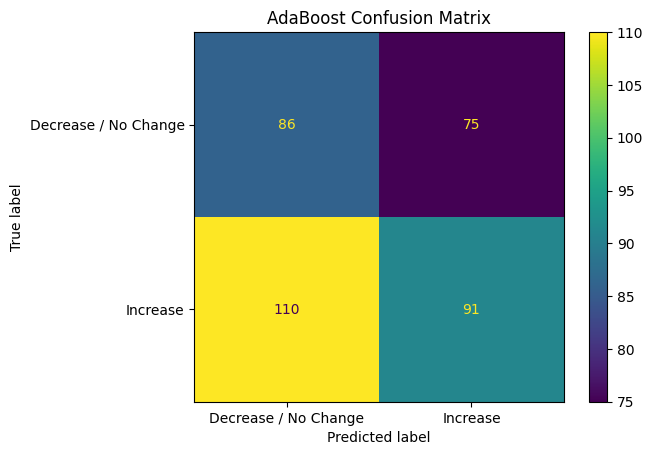

Random guess trial
Accuracy: 0.5248618784530387
f1 score: 0.5497382198952879
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       161
           1       0.58      0.52      0.55       201

    accuracy                           0.52       362
   macro avg       0.52      0.53      0.52       362
weighted avg       0.53      0.52      0.53       362



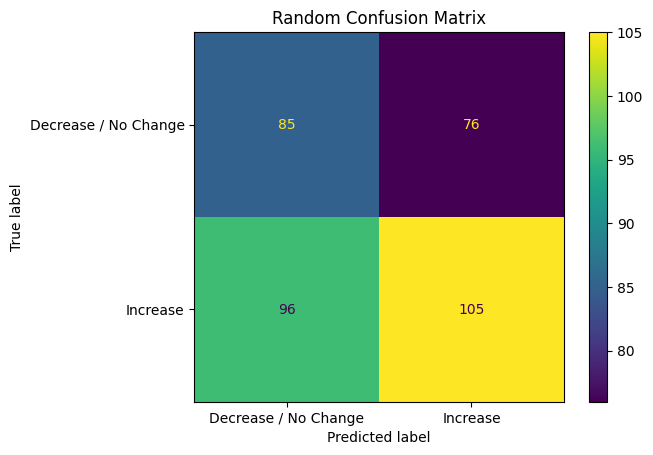

"To the moon!" trial
Accuracy: 0.5552486187845304
f1 score: 0.7140319715808171 


Fold 0: 1574 samples in training set and 788 samples in test set
Fold 1: 1575 samples in training set and 787 samples in test set
Fold 2: 1575 samples in training set and 787 samples in test set


Average AdaBoost accuracy: 0.53
Average AdaBoost f1 score: 0.68
Average random accuracy: 0.49
Average random f1 score: 0.5
Average ttm accuracy: 0.52
Average ttm f1 score: 0.69


In [5]:
##########################################################
#Single trial, like in midterm report
split_point = 2000
X_train = X[:split_point]
X_test = X[split_point:]
X_0_train = X_0[:split_point]
X_0_test = X_0[split_point:]
y_train = y_clas[:split_point]
y_test = y_clas[split_point:]

#AdaBoost
btree = DecisionTreeClassifier(max_depth = 5)
ada = AdaBoostClassifier(estimator = btree, algorithm = 'SAMME', n_estimators = 1000, learning_rate = 3.5)
ada.fit(X_train, y_train)
y_ada = ada.predict(X_test)
print("AdaBoost trial")
print(f"Accuracy: {accuracy_score(y_test, y_ada)}")
print("f1 score:", f1_score(y_test, y_ada))
print(classification_report(y_test, y_ada))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_ada, display_labels=['Decrease / No Change', 'Increase'])
plt.title("AdaBoost Confusion Matrix")
plt.show()

#Random Guess
rng = np.random.default_rng()
random_guess = rng.integers(2, size = len(y_test))
print("Random guess trial")
print(f"Accuracy: {accuracy_score(y_test, random_guess)}")
print("f1 score:", f1_score(y_test, random_guess))
print(classification_report(y_test, random_guess))
disp = ConfusionMatrixDisplay.from_predictions(y_test, random_guess, display_labels=['Decrease / No Change', 'Increase'])
plt.title("Random Confusion Matrix")
plt.show()

#To The Moon!
ttm = np.ones(len(y_test))
print("\"To the moon!\" trial")
print(f"Accuracy: {accuracy_score(y_test, ttm)}")
print("f1 score:", f1_score(y_test, ttm), "\n\n")


########################################################################
#Use K-folds validation
kf = KFold(n_splits = 3, shuffle = True, random_state = 325)
ada_acc = []
ada_f1 = []
rand_acc = []
rand_f1 = []
ttm_acc = []
ttm_f1 = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    print(f"Fold {i}: {len(train_index)} samples in training set and {len(test_index)} samples in test set")
    for index in train_index:
        X_train.append(X[index])
        y_train.append(y_clas[index])
    for index in test_index:    
        X_test.append(X[index])
        y_test.append(y_clas[index])

    btree = DecisionTreeClassifier(max_depth = 2)
    ada = AdaBoostClassifier(estimator = btree, algorithm = 'SAMME', n_estimators = 1000, learning_rate = 3.5)
    ada.fit(X_train, y_train)
    y_ada = ada.predict(X_test)
    rng = np.random.default_rng()
    random_guess = rng.integers(2, size = len(y_test))
    ttm = np.ones(len(y_test))
    ada_acc.append(accuracy_score(y_test, y_ada))
    ada_f1.append(f1_score(y_test, y_ada))
    rand_acc.append(accuracy_score(y_test, random_guess))
    rand_f1.append(f1_score(y_test, random_guess))
    ttm_acc.append(accuracy_score(y_test, ttm))
    ttm_f1.append(f1_score(y_test, ttm))
    #Include these for more info
    ###print(f"   AdaBoost: Accuracy of {np.round(accuracy_score(y_test, y_ada), 2)}, f1 score of {np.round(f1_score(y_test, y_ada), 2)}")
    ###print(f"   Random Guess: Accuracy of {np.round(accuracy_score(y_test, random_guess), 2)}, f1 score of {np.round(f1_score(y_test, random_guess), 2)}")
    ###print(f"   TTM: Accuracy of {np.round(accuracy_score(y_test, ttm), 2)}, f1 score of {np.round(f1_score(y_test, ttm), 2)}")

print("\n\nAverage AdaBoost accuracy:", np.round(np.mean(ada_acc), 2))
print("Average AdaBoost f1 score:", np.round(np.mean(ada_f1), 2))
print("Average random accuracy:", np.round(np.mean(rand_acc), 2))
print("Average random f1 score:", np.round(np.mean(rand_f1), 2))
print("Average ttm accuracy:", np.round(np.mean(ttm_acc), 2))
print("Average ttm f1 score:", np.round(np.mean(ttm_f1), 2))